# Working with images in python

## array to image to file

Create an image as a set of rgb values in an numpy array, convert it to pil image and write a png. First explore 
the image arrary data structure. To do that we read an image into an PIL image and then convert it to an ndarray. Then we can explore the data layout. Later we build an array and convert it to an image with PIL. Then display that image to see if the pixels end up where we think they will. 


In [12]:
#import stuff and read the image
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
%matplotlib inline
imagefile = os.path.join(os.path.expanduser("~"),"Desktop\lenna.png")
im = Image.open(imagefile)

In [13]:
type(im)
imarray = np.array(im)
imarray.shape

(512, 512, 3)

The dimensions of our image array are shown above. It looks like the standard "C" ordering has the pixel rgb values stored as an array of triples by row. The first pixel is:

In [14]:
imarray[0,0]

array([226, 137, 125], dtype=uint8)

The first three pixels in the top row are:

In [15]:
imarray[0,0:3]

array([[226, 137, 125],
       [226, 137, 125],
       [223, 137, 133]], dtype=uint8)

Build an array and morph it into an image. This bit of code builds a 200 by 100 (wxh) image by creating an array of integers 0 < x < 255. It does that by scaling the r,g, and b values linearly with the width and height of the image. Red is scaled from left to right, green is scaled from top to bottom and blue is constant at 0.2 times 255. In order to insure the scaling is correct the calculations are done in floating point and then converted to int by chopping off the remainder. Thus value = float(i)/float(nx)X255.9; 0 <= i <= nx gives i/nx between 0 and 1.0. This leads to 0 <= value <= 255.9. Which gives the correct integer value. Note that the array must be dtype = np.uint8. Using np.int8 is wrong because it is a signed value that goes from -127 - 127.

we need to take care of how the image data is set up. The data is loaded in "C" order or by rows rather than columns. This means for an image that has a width of nx and height of ny we have to create a numpy array with the shape (height,width,colors). This means the rgb values will be contiguous in memory. pixels will be contiguous in the nx direction followed by ny. See the code below for loading index math. Also note that for the image data the zeroth row of the data is displayed at the top of the image. Graphics convention is the origin of the image is at the bottom left corner of the data. This has to be corrected for when loading the array to ensure the image isnt upside down. this could be accomplished when traversing and loading the array or one could use an image transform after the fact.  Again see below for the first method.

In [4]:
nx=200
ny=100
testimagearray = np.zeros((ny,nx,3),dtype=np.uint8)
b = int(255.9*0.0)
maxj = np.arange(ny)[-1]
for j in np.arange(ny):
    g = int(255.9*float(maxj - j)/float(ny)) #flip the y axis. 
    for i in np.arange(nx):
        r = int(255.9*float(i)/float(nx))
        testimagearray[j,i] = [r,g,b]

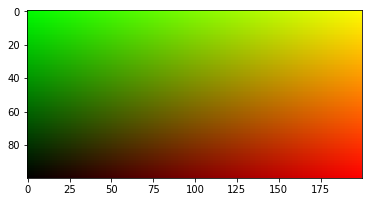

In [5]:
#explore the array
newimage = Image.fromarray(testimagearray)
plt.imshow(newimage)

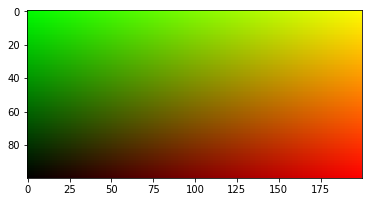

In [6]:
#lets make another test image and flip it using pil rather than programatically
testimagearray2 = np.zeros((ny,nx,3),dtype=np.uint8)
b = int(255.9*0.0)
for j in np.arange(ny):
    g = int(255.9*float( j)/float(ny))  
    for i in np.arange(nx):
        r = int(255.9*float(i)/float(nx))
        testimagearray2[j,i] = [r,g,b]
# now flip and display
newimage2 = Image.fromarray(testimagearray2)
plt.imshow(ImageOps.flip(newimage2))

Now we want to save the image to a file. Again using pil module. 

In [16]:
# save the first newimage
newimage.save("..\Images\colorblah.png","PNG")